<a href="https://colab.research.google.com/github/Parvez13/TensorFlow-Developer-Certification/blob/master/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1 : Feature Extraction

Transfer learning is leveraging a working model's existing architectures and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue Jul 20 02:45:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-20 02:45:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   128MB/s    in 1.3s    

2021-07-20 02:45:09 (128 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os 

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("dir"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                     target_size=IMAGE_SHAPE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical')


print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode = 'categorical')



Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training(before it trains too long and overfits) with the EarlyStopping callback


In [5]:
# Create TensorBoard Callback (functionized because we need to create a new one for each model)
import datetime


def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

> 🔑 **Note:** You can customize the directory where your TensoBoard logs(model training metrics)get saved to whatever you like.
The `log_dir` paramter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TendorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet  model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
history = resnet_model.fit(train_data_10_percent,
                           batch_size=32,
                           epochs=5,
                           steps_per_epoch =len(train_data_10_percent),
                           validation_data=test_data,
                           validation_steps=len(test_data),
                           callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                  experiment_name='resnet50v2')])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20210720-025359
Epoch 1/5
24/24 [==============================] - 17s 727ms/step - loss: 0.2251 - accuracy: 0.9667 - val_loss: 0.6307 - val_accuracy: 0.7924
Epoch 2/5
24/24 [==============================] - 16s 688ms/step - loss: 0.1922 - accuracy: 0.9733 - val_loss: 0.6340 - val_accuracy: 0.7824
Epoch 3/5
24/24 [==============================] - 15s 662ms/step - loss: 0.1674 - accuracy: 0.9813 - val_loss: 0.6218 - val_accuracy: 0.7900
Epoch 4/5
24/24 [==============================] - 15s 655ms/step - loss: 0.1440 - accuracy: 0.9893 - val_loss: 0.6280 - val_accuracy: 0.7896
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.1293 - accuracy: 0.9920 - val_loss: 0.6184 - val_accuracy: 0.7924




That is incredible. Our Transfer Learning feature extractor model out performed ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% of the training examples

In [25]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it..
import matplotlib.pyplot as plt


# Plot the validation and training curves
def plot_loss_curves(history):
  """

  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History Object
  
  Returns:
    Plots of training/validation loss and accuracy metrics

  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # PLot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()



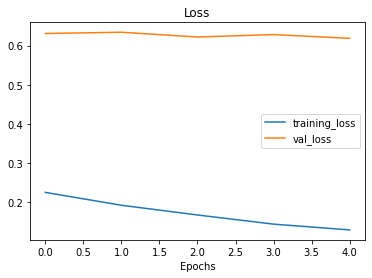

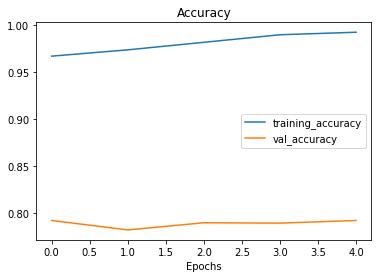

In [26]:
plot_loss_curves(history=history)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [13]:
# Efficienet model
efficientnet_model = create_model(efficientnet_url,
                                   num_classes=train_data_10_percent.num_classes)


In [20]:
# compile the model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [21]:
# Let's fit our efficient model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                               epochs=5,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=len(test_data),
                                               callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                    experiment_name='efficientnet')])

Saving TensorBoard log files to : tensorflow_hub/efficientnet/20210720-025754
Epoch 1/5
24/24 [==============================] - 68s 764ms/step - loss: 1.7691 - accuracy: 0.4933 - val_loss: 1.2350 - val_accuracy: 0.7568
Epoch 2/5
24/24 [==============================] - 16s 666ms/step - loss: 1.0302 - accuracy: 0.7813 - val_loss: 0.8391 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 15s 647ms/step - loss: 0.7444 - accuracy: 0.8440 - val_loss: 0.6813 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 15s 627ms/step - loss: 0.5971 - accuracy: 0.8707 - val_loss: 0.6026 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 14s 618ms/step - loss: 0.5080 - accuracy: 0.8947 - val_loss: 0.5517 - val_accuracy: 0.8656


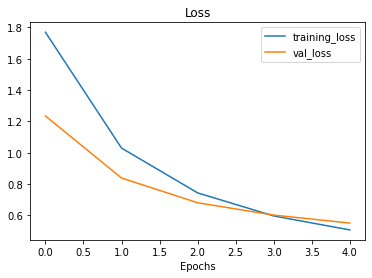

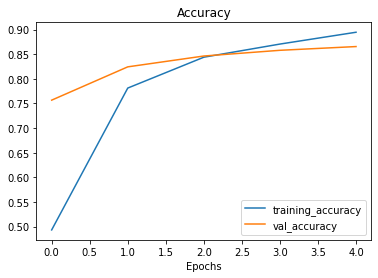

In [27]:
plot_loss_curves(history=efficientnet_history)

In [28]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [32]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 IMagenet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food )
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models results Using TensorBoard


> 🔑 **Note:**  When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
    --one_shot 

Our TensorBoard experiiments are uploaded publically here : https://tensorboard.dev/experiment/ikeyYyapS0qx4VG02kCZqA/

In [36]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-07-20 04:08:13.240835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/ikeyYyapS0qx4VG02kCZqA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   ikeyYyapS0qx4VG02kCZqA
	Created              2021-07-20 04:02:02 (6 minutes ago)
	Updated              2021-07-20 04:02:05 (6 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              66
	Tensor bytes         0
	Binary object bytes  7744153
Total: 1 experiment(s)
